In [13]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 36.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 30.9 MB/s eta 0:00:0000:0100:01


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# load in dataset

#### Load in the dataset

data = pd.read_csv("/home/dermot.kelly/Dermot_analysis/Phd/Paper_2/microbiome_ml/data/CLR_micro.csv", sep=",", header=0)

#abund_log.head()

In [3]:
for i, col in enumerate(data.columns):
    print(i, col)


0 VID
1 EID
2 micro_date
3 ANI_ID
4 ch4_g_day2_1v3
5 source
6 date
7 animal_type
8 diet_type
9 hr_off_feed
10 lot_no
11 chamber
12 hum
13 press
14 temp
15 weight
16 ch4_1
17 ch4_2
18 ch4_3
19 co2_1
20 co2_2
21 co2_3
22 o2_1
23 o2_2
24 o2_3
25 time_r1
26 time_r2
27 time_r3
28 ch4_l_hour_1v3
29 ch4_l_day_1v3
30 ch4_g_hour_1v3
31 ch4_l_hour_2v3
32 ch4_l_day_2v3
33 ch4_g_hour_2v3
34 ch4_g_day2_2v3
35 ch4_l_hour_1v2
36 ch4_l_day_1v2
37 ch4_g_hour_1v2
38 ch4_g_day2_1v2
39 o2_l_hour_1v3
40 o2_l_day_1v3
41 o2_g_hour_1v3
42 o2_g_day2_1v3
43 o2_l_hour_2v3
44 o2_l_day_2v3
45 o2_g_hour_2v3
46 o2_g_day2_2v3
47 o2_l_hour_1v2
48 o2_l_day_1v2
49 o2_g_hour_1v2
50 o2_g_day2_1v2
51 co2_l_hour_1v3
52 co2_l_day_1v3
53 co2_g_hour_1v3
54 co2_g_day2_1v3
55 co2_l_hour_2v3
56 co2_l_day_2v3
57 co2_g_hour_2v3
58 co2_g_day2_2v3
59 co2_l_hour_1v2
60 co2_l_day_1v2
61 co2_g_hour_1v2
62 co2_g_day2_1v2
63 flow_rate
64 Rate_flow
65 first_lambing_date
66 ewe_check
67 age_at_treatment
68 growing_check
69 Age_in_months
70 

In [3]:
# So need to just pull the columns that we need for models

genera_cols = data.columns[343:501].tolist()

pheno_cols = ["ANI_ID", "ch4_g_day2_1v3", "SEX", "Age_in_months", "main_breed", "weight"]

ml_df = data[pheno_cols + genera_cols].dropna()

print(f"Final dataset shape: {ml_df.shape}")

Final dataset shape: (356, 164)


In [5]:
from sklearn.preprocessing import OneHotEncoder

In [6]:
# Have to set categorical variables to numeric and drop one

categorical_vars = ["SEX", "main_breed"]
encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded = encoder.fit_transform(ml_df[categorical_vars])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_vars), index=ml_df.index)

In [7]:
# Create the final feature matrix and then methane target

X = pd.concat([ml_df[["Age_in_months", "weight"] + genera_cols], encoded_df], axis=1)
y = ml_df["ch4_g_day2_1v3"]


In [10]:
# Split for CV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
from sklearn.model_selection import RandomizedSearchCV

In [12]:
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=50,
    cv=10,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X, y)
print("Best RF Params:", rf_random.best_params_)

Best RF Params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}


In [13]:
xgb_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0.1, 1, 10]
}

xgb_random = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=50,
    cv=10,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

xgb_random.fit(X, y)
print("Best XGBoost Params:", xgb_random.best_params_)


Best XGBoost Params: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.6}


In [9]:
# Best RF model
rf_model = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features=None,
    max_depth=None,
    random_state=42
)

# Best XGBoost model
xgb_model = XGBRegressor(
    subsample=1.0,
    reg_lambda=0.1,
    reg_alpha=0,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    gamma=1,
    colsample_bytree=0.6,
    verbosity=0,
    random_state=42
)

In [10]:
# Cool so cross validation now, we'll go ten fold cos why not
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

In [ ]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# R² scores
rf_r2_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='r2')
xgb_r2_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='r2')

# MSE scores (note the negative sign)
rf_mse_scores = -cross_val_score(rf_model, X, y, cv=cv, scoring='neg_mean_squared_error')
xgb_mse_scores = -cross_val_score(xgb_model, X, y, cv=cv, scoring='neg_mean_squared_error')

# Report results
print("Random Forest R²: Mean =", rf_r2_scores.mean(), "Std =", rf_r2_scores.std())
print("Random Forest MSE: Mean =", rf_mse_scores.mean(), "Std =", rf_mse_scores.std())

print("XGBoost R²: Mean =", xgb_r2_scores.mean(), "Std =", xgb_r2_scores.std())
print("XGBoost MSE: Mean =", xgb_mse_scores.mean(), "Std =", xgb_mse_scores.std())

In [18]:
# Retrain Random Forest with best parameters on full dataset
rf_best = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=20,
    random_state=42
)
rf_best.fit(X, y)

# Retrain XGBoost with best parameters on full dataset
xgb_best = XGBRegressor(
    subsample=0.6,
    reg_lambda=1,
    reg_alpha=0,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    gamma=0,
    colsample_bytree=0.8,
    verbosity=0,
    random_state=42
)
xgb_best.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
# Feature importance from best Random Forest
rf_importances = pd.Series(rf_best.feature_importances_, index=X.columns).sort_values(ascending=False)

# Feature importance from best XGBoost
xgb_importances = pd.Series(xgb_best.feature_importances_, index=X.columns).sort_values(ascending=False)


In [22]:
rf_importances.head(50)

Lachnospiraceae_UCG.008                0.042236
Absconditabacteriales_.SR1.            0.035994
Streptococcus                          0.034980
Methanobrevibacter                     0.025603
F082                                   0.025027
Bacteroidales_BS11_gut_group           0.024569
Sediminispirochaeta                    0.024546
main_breed_TX                          0.023424
weight                                 0.022305
Erysipelotrichaceae_UCG.008            0.021838
Prevotellaceae_UCG.001                 0.021633
Desulfovibrio                          0.019363
uncultured                             0.019201
Fretibacterium                         0.016170
Campylobacter                          0.015494
RF39                                   0.015220
Prevotellaceae                         0.014223
Bacteroides                            0.013692
Candidatus_Saccharimonas               0.013505
Bacteroidales_RF16_group               0.013329
Tuzzerella                             0

In [23]:
xgb_importances.head(50)

Lachnospiraceae_UCG.008              0.076233
Absconditabacteriales_.SR1.          0.033596
Sediminispirochaeta                  0.029764
Bacteroides                          0.027426
Fretibacterium                       0.026070
Tuzzerella                           0.024970
main_breed_TX                        0.021657
Flexilinea                           0.020354
Schwartzia                           0.019891
Bibersteinia                         0.019200
Streptococcus                        0.017980
UCG.002                              0.017118
Candidatus_Saccharimonas             0.015804
F082                                 0.015791
SP3.e08                              0.014843
Lachnospiraceae_UCG.010              0.014589
UCG.001                              0.014398
Lachnoanaerobaculum                  0.013952
Kandleria                            0.013798
X.Eubacterium._ruminantium_group     0.013702
RF39                                 0.012640
uncultured                        

In [37]:
import matplotlib.pyplot as plt

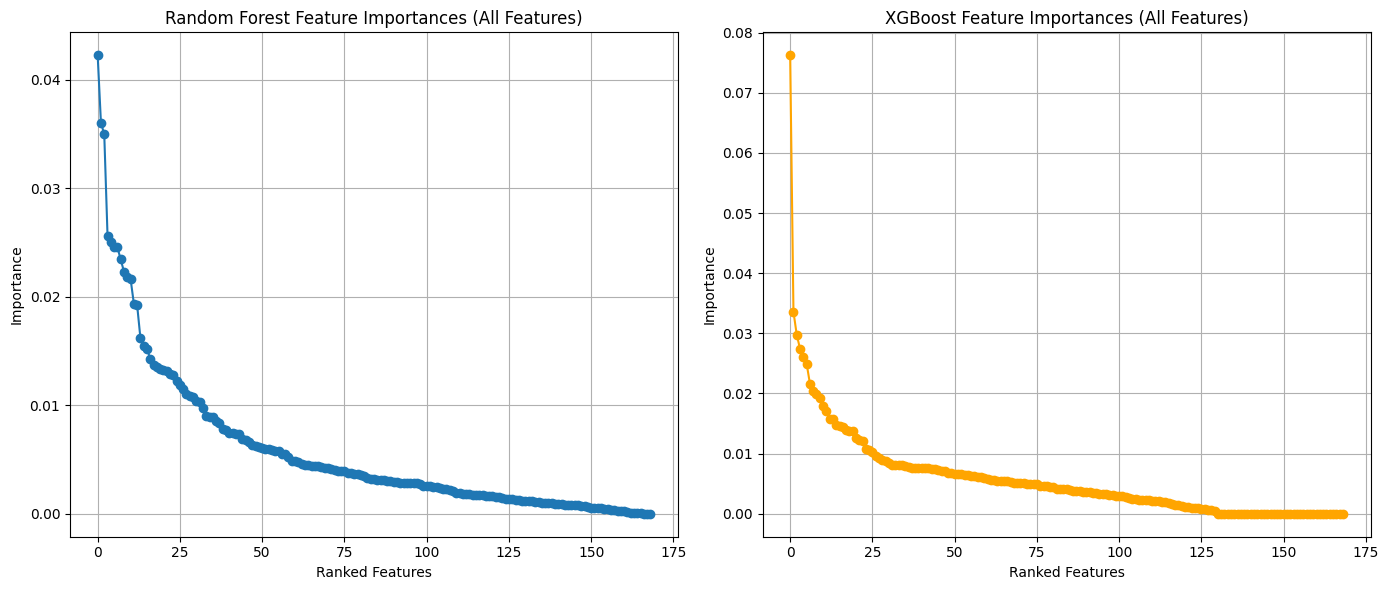

In [24]:
# lets visually assess to see if theres much variation in predictive power

plt.figure(figsize=(14, 6))

# Random Forest
plt.subplot(1, 2, 1)
plt.plot(rf_importances.values, marker='o')
plt.title("Random Forest Feature Importances (All Features)")
plt.ylabel("Importance")
plt.xlabel("Ranked Features")
plt.grid(True)

# XGBoost
plt.subplot(1, 2, 2)
plt.plot(xgb_importances.values, marker='o', color='orange')
plt.title("XGBoost Feature Importances (All Features)")
plt.ylabel("Importance")
plt.xlabel("Ranked Features")
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
rf_importances_df = rf_importances.reset_index()
rf_importances_df.columns = ["Feature", "Importance"]
rf_importances_df.to_csv("/home/dermot.kelly/Dermot_analysis/Phd/Paper_2/microbiome_ml/data/random_forest_feature_importance.csv", index=False)

xgb_importances_df = xgb_importances.reset_index()
xgb_importances_df.columns = ["Feature", "Importance"]
xgb_importances_df.to_csv("/home/dermot.kelly/Dermot_analysis/Phd/Paper_2/microbiome_ml/data/xgboost_feature_importance.csv", index=False)
